In [1]:
import sys
# sys.path.insert(0, '../../Utilities/')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
#from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time
# tf.enable_eager_execution()
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [2]:
class PhysicsInformedNN3:
    # Initialize the class
    def __init__(self, X, u, layers, lb, ub, q):
        
        self.loss_array= []
        self.lambda_array= []
        
        
        self.lb = lb
        self.ub = ub
        
        self.x = X[:,0:1]
        self.t = X[:,1:2]
        self.u = u
        
        self.layers = layers
        self.q = q
        
        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        # Initialize parameters
        self.lambda_1 = tf.Variable([0.0], dtype=tf.float32)
        self.lambda_2 = tf.Variable([1.0], dtype=tf.float32)
        
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
                
        self.u_pred = self.net_u(self.x_tf, self.t_tf)
        self.f_pred = self.net_f(self.x_tf, self.t_tf)
        
        self.loss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) + \
                    tf.reduce_mean(tf.square(self.f_pred))
        
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
    
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = (X - self.lb)/(self.ub - self.lb) 
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.math.sigmoid(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
            
    def net_u(self, x, t):  
        u = self.neural_net(tf.concat([x,t],1), self.weights, self.biases)
        return u
    
    def net_f(self, x, t):
        lambda_1 = self.lambda_1        
        q = self.q 
        u = self.net_u(x,t)
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
#         f= q+ lambda_1*u_x
        f = q + lambda_1*(u_t) 
        
        return f
    
    def callback(self, loss, lambda_1, lambda_2):
        print('Loss: %e, l1: %.5f, l2: %.5f' % (loss, lambda_1, lambda_2))
        
        
    def train(self, nIter):
        tf_dict = {self.x_tf: self.x, self.t_tf: self.t, self.u_tf: self.u}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                lambda_1_value = self.sess.run(self.lambda_1)
                lambda_2_value = self.sess.run(self.lambda_2)
                
                self.loss_array.append(loss_value)
                self.lambda_array.append(lambda_1_value)
#                 lolz= self.sess.run(self.net_f(self.x_tf,self.t_tf) , tf_dict)
                print('It: %d, Loss: %.3e, Lambda_1: %.3f, Lambda_2: %.6f, Time: %.2f' % 
                      (it, loss_value, lambda_1_value, lambda_2_value, elapsed))
#                 print(lolz)
                start_time = time.time()
        
#         self.optimizer_Adam.minimize(self.loss)
        
        
#         self.optimizer.minimize(self.sess,
#                                 feed_dict = tf_dict,
#                                 fetches = [self.loss, self.lambda_1, self.lambda_2],
#                                 loss_callback = self.callback)
        
        
    def predict(self, X_star):
        
        tf_dict = {self.x_tf: X_star[:,0:1], self.t_tf: X_star[:,1:2]}
        
        u_star = self.sess.run(self.u_pred, tf_dict)
        f_star = self.sess.run(self.f_pred, tf_dict)
        
        return u_star, f_star

In [3]:
df= pd.read_csv(r"C:\Users\Omkar\Downloads\NEW TEMP AND FLUX (XZ)_.csv")

In [4]:
df

,X Location (m),Z Location (m),Temperature (K),Heat Flux (W/mK),Unnamed: 4
0,1.00000,1.00000,1.00000,0.25,NaN
1,1.00000,0.00000,0.50004,0.25,NaN
2,1.00000,0.99500,0.99750,0.25,NaN
3,1.00000,0.99000,0.99500,0.25,NaN
4,1.00000,0.98500,0.99250,0.25,NaN
...,...,...,...,...,...
161599,-0.35000,-0.59000,0.20502,0.25,NaN
161600,-0.20000,-0.68000,0.16001,0.25,NaN
161601,-0.75000,-0.40000,0.30002,0.25,NaN
161602,-0.60000,-0.75000,0.12501,0.25,NaN


In [5]:
q=df.loc[:,["Heat Flux (W/mK)" ]] 

In [6]:
q_final=-np.array(q)

In [7]:
x_z=df.loc[:,["X Location (m)","Z Location (m)" ]] 

In [8]:
x_z=np.array(x_z)

In [9]:
u=df.loc[:,"Temperature (K)"]

In [10]:
u=np.array(u)

In [11]:
u=u.reshape(161604,1)

In [12]:
layers2 = [2, 20, 20, 20, 20, 1]

In [13]:
N_u=30


In [14]:
lb1 = x_z.min(0)
ub1 = x_z.max(0)

In [49]:
idx = np.random.choice(x_z.shape[0], N_u, replace=False)
X_u_train = x_z[idx,:]
u_train = u[idx,:]
q_= q_final[idx,:]
q_t= tf.convert_to_tensor(q_,dtype=tf.float32)

In [16]:
model = PhysicsInformedNN3(X_u_train, u_train, layers2, lb1, ub1 , q_t)
model.train(10000)

Device mapping:

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

It: 0, Loss: 4.697e-01, Lambda_1: 0.001, Lambda_2: 1.000000, Time: 0.15
It: 10, Loss: 2.264e-01, Lambda_1: 0.011, Lambda_2: 1.000000, Time: 0.03
It: 20, Loss: 1.500e-01, Lambda_1: 0.021, Lambda_2: 1.000000, Time: 0.02
It: 30, Loss: 1.519e-01, Lambda_1: 0.031, Lambda_2: 1.000000, Time: 0.02
It: 40, Loss: 1.518e-01, Lambda_1: 0.041, Lambda_2: 1.000000, Time: 0.02
It: 50, Loss: 1.477e-01, Lambda_1: 0.051, Lambda_2: 1.000000, Time: 0.01
It: 60, Loss: 1.476e-01, Lambda_1: 0.061, Lambda_2: 1.000000, Time: 0.01
It: 70, Loss: 1.475e-01, Lambda_1: 0.072, Lambda_2: 1.000000, Time: 0.01
It: 80, Loss: 1.473e-01, Lambda_1: 0

It: 1190, Loss: 7.966e-04, Lambda_1: 0.523, Lambda_2: 1.000000, Time: 0.01
It: 1200, Loss: 7.912e-04, Lambda_1: 0.522, Lambda_2: 1.000000, Time: 0.01
It: 1210, Loss: 7.858e-04, Lambda_1: 0.522, Lambda_2: 1.000000, Time: 0.01
It: 1220, Loss: 7.805e-04, Lambda_1: 0.522, Lambda_2: 1.000000, Time: 0.01
It: 1230, Loss: 7.752e-04, Lambda_1: 0.522, Lambda_2: 1.000000, Time: 0.01
It: 1240, Loss: 7.699e-04, Lambda_1: 0.522, Lambda_2: 1.000000, Time: 0.01
It: 1250, Loss: 7.646e-04, Lambda_1: 0.522, Lambda_2: 1.000000, Time: 0.01
It: 1260, Loss: 7.594e-04, Lambda_1: 0.522, Lambda_2: 1.000000, Time: 0.01
It: 1270, Loss: 7.542e-04, Lambda_1: 0.522, Lambda_2: 1.000000, Time: 0.01
It: 1280, Loss: 7.490e-04, Lambda_1: 0.522, Lambda_2: 1.000000, Time: 0.01
It: 1290, Loss: 7.438e-04, Lambda_1: 0.522, Lambda_2: 1.000000, Time: 0.01
It: 1300, Loss: 7.387e-04, Lambda_1: 0.522, Lambda_2: 1.000000, Time: 0.01
It: 1310, Loss: 7.336e-04, Lambda_1: 0.522, Lambda_2: 1.000000, Time: 0.01
It: 1320, Loss: 7.285e-04

It: 2330, Loss: 3.283e-04, Lambda_1: 0.517, Lambda_2: 1.000000, Time: 0.03
It: 2340, Loss: 3.253e-04, Lambda_1: 0.517, Lambda_2: 1.000000, Time: 0.02
It: 2350, Loss: 3.224e-04, Lambda_1: 0.517, Lambda_2: 1.000000, Time: 0.02
It: 2360, Loss: 3.195e-04, Lambda_1: 0.517, Lambda_2: 1.000000, Time: 0.02
It: 2370, Loss: 3.167e-04, Lambda_1: 0.517, Lambda_2: 1.000000, Time: 0.02
It: 2380, Loss: 3.138e-04, Lambda_1: 0.517, Lambda_2: 1.000000, Time: 0.02
It: 2390, Loss: 3.110e-04, Lambda_1: 0.517, Lambda_2: 1.000000, Time: 0.02
It: 2400, Loss: 3.082e-04, Lambda_1: 0.517, Lambda_2: 1.000000, Time: 0.02
It: 2410, Loss: 3.055e-04, Lambda_1: 0.517, Lambda_2: 1.000000, Time: 0.02
It: 2420, Loss: 3.028e-04, Lambda_1: 0.517, Lambda_2: 1.000000, Time: 0.03
It: 2430, Loss: 3.000e-04, Lambda_1: 0.517, Lambda_2: 1.000000, Time: 0.03
It: 2440, Loss: 2.974e-04, Lambda_1: 0.517, Lambda_2: 1.000000, Time: 0.02
It: 2450, Loss: 2.947e-04, Lambda_1: 0.517, Lambda_2: 1.000000, Time: 0.02
It: 2460, Loss: 2.921e-04

It: 3500, Loss: 1.026e-04, Lambda_1: 0.511, Lambda_2: 1.000000, Time: 0.01
It: 3510, Loss: 1.012e-04, Lambda_1: 0.511, Lambda_2: 1.000000, Time: 0.01
It: 3520, Loss: 9.970e-05, Lambda_1: 0.511, Lambda_2: 1.000000, Time: 0.01
It: 3530, Loss: 9.824e-05, Lambda_1: 0.511, Lambda_2: 1.000000, Time: 0.01
It: 3540, Loss: 9.679e-05, Lambda_1: 0.511, Lambda_2: 1.000000, Time: 0.01
It: 3550, Loss: 9.534e-05, Lambda_1: 0.511, Lambda_2: 1.000000, Time: 0.01
It: 3560, Loss: 9.389e-05, Lambda_1: 0.511, Lambda_2: 1.000000, Time: 0.01
It: 3570, Loss: 9.245e-05, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.01
It: 3580, Loss: 9.102e-05, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.01
It: 3590, Loss: 8.959e-05, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.01
It: 3600, Loss: 8.817e-05, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.01
It: 3610, Loss: 8.675e-05, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.01
It: 3620, Loss: 8.534e-05, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.01
It: 3630, Loss: 8.394e-05

It: 4760, Loss: 2.233e-06, Lambda_1: 0.502, Lambda_2: 1.000000, Time: 0.01
It: 4770, Loss: 1.975e-06, Lambda_1: 0.502, Lambda_2: 1.000000, Time: 0.01
It: 4780, Loss: 1.859e-06, Lambda_1: 0.502, Lambda_2: 1.000000, Time: 0.01
It: 4790, Loss: 1.769e-06, Lambda_1: 0.502, Lambda_2: 1.000000, Time: 0.01
It: 4800, Loss: 1.685e-06, Lambda_1: 0.502, Lambda_2: 1.000000, Time: 0.01
It: 4810, Loss: 1.622e-06, Lambda_1: 0.502, Lambda_2: 1.000000, Time: 0.01
It: 4820, Loss: 1.560e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 4830, Loss: 1.500e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 4840, Loss: 1.445e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 4850, Loss: 1.393e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 4860, Loss: 1.343e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 4870, Loss: 1.296e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 4880, Loss: 1.252e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 4890, Loss: 1.210e-06

It: 6000, Loss: 4.864e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 6010, Loss: 4.856e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 6020, Loss: 4.847e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 6030, Loss: 4.839e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 6040, Loss: 4.831e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 6050, Loss: 4.824e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 6060, Loss: 4.816e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 6070, Loss: 4.808e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 6080, Loss: 4.800e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 6090, Loss: 4.793e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 6100, Loss: 4.786e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 6110, Loss: 4.782e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 6120, Loss: 5.176e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 6130, Loss: 7.216e-06

It: 7140, Loss: 4.308e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 7150, Loss: 4.304e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 7160, Loss: 4.301e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.03
It: 7170, Loss: 4.298e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 7180, Loss: 4.326e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 7190, Loss: 1.087e-06, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 7200, Loss: 5.446e-05, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 7210, Loss: 9.098e-06, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 7220, Loss: 3.557e-06, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 7230, Loss: 1.844e-06, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 7240, Loss: 1.001e-06, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 7250, Loss: 6.326e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 7260, Loss: 4.903e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 7270, Loss: 4.408e-07

It: 8250, Loss: 4.082e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 8260, Loss: 4.081e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 8270, Loss: 4.079e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 8280, Loss: 4.077e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 8290, Loss: 4.075e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 8300, Loss: 4.073e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 8310, Loss: 4.071e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 8320, Loss: 4.070e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 8330, Loss: 4.068e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 8340, Loss: 4.066e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.03
It: 8350, Loss: 4.075e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 8360, Loss: 4.951e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 8370, Loss: 1.355e-05, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 8380, Loss: 1.485e-05

It: 9350, Loss: 3.953e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.03
It: 9360, Loss: 3.947e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.03
It: 9370, Loss: 3.945e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 9380, Loss: 3.943e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 9390, Loss: 3.942e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 9400, Loss: 3.940e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 9410, Loss: 3.939e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 9420, Loss: 3.937e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 9430, Loss: 3.936e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 9440, Loss: 3.935e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.03
It: 9450, Loss: 3.933e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 9460, Loss: 3.932e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 9470, Loss: 3.930e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 9480, Loss: 3.929e-07

In [17]:
arr=[]
for i in range(0,10000):
    if i%10==0:
        arr.append(i)

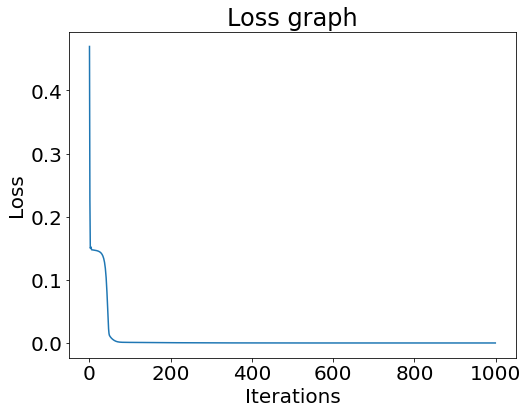

In [22]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Loss')
  
# giving a title to my graph
plt.title('Loss graph')
  
x = arr
y = model.loss_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([0, 10**-2])
plt.show()

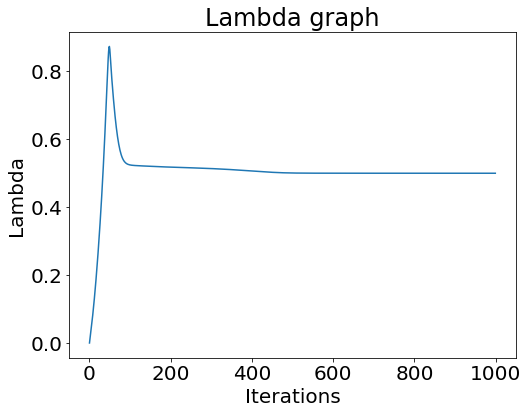

In [23]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Lambda')
  
# giving a title to my graph
plt.title('Lambda graph')
  
x = arr
y = model.lambda_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([5.5, 6])
plt.show()

In [15]:
noise1 = 0.01        
u_train2 = u_train + noise1*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])



In [31]:
model2 = PhysicsInformedNN3(X_u_train, u_train2, layers2, lb1, ub1 , q_t)
model2.train(10000)

Device mapping:

It: 0, Loss: 1.341e-01, Lambda_1: 0.001, Lambda_2: 1.000000, Time: 0.31
It: 10, Loss: 1.280e-01, Lambda_1: 0.011, Lambda_2: 1.000000, Time: 0.01
It: 20, Loss: 1.264e-01, Lambda_1: 0.022, Lambda_2: 1.000000, Time: 0.01
It: 30, Loss: 1.258e-01, Lambda_1: 0.033, Lambda_2: 1.000000, Time: 0.01
It: 40, Loss: 1.256e-01, Lambda_1: 0.045, Lambda_2: 1.000000, Time: 0.01
It: 50, Loss: 1.255e-01, Lambda_1: 0.058, Lambda_2: 1.000000, Time: 0.01
It: 60, Loss: 1.255e-01, Lambda_1: 0.071, Lambda_2: 1.000000, Time: 0.01
It: 70, Loss: 1.254e-01, Lambda_1: 0.085, Lambda_2: 1.000000, Time: 0.01
It: 80, Loss: 1.253e-01, Lambda_1: 0.100, Lambda_2: 1.000000, Time: 0.01
It: 90, Loss: 1.251e-01, Lambda_1: 0.116, Lambda_2: 1.000000, Time: 0.01
It: 100, Loss: 1.250e-01, Lambda_1: 0.132, Lambda_2: 1.000000, Time: 0.01
It: 110, Loss: 1.248e-01, Lambda_1: 0.148, Lambda_2: 1.000000, Time: 0.01
It: 120, Loss: 1.245e-01, Lambda_1: 0.166, Lambda_2: 1.000000, Time: 0.01
It: 130, Loss: 1.242e-01, Lambda

It: 1190, Loss: 1.494e-04, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.01
It: 1200, Loss: 1.486e-04, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.01
It: 1210, Loss: 1.478e-04, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.01
It: 1220, Loss: 1.470e-04, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.01
It: 1230, Loss: 1.461e-04, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.01
It: 1240, Loss: 1.453e-04, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.01
It: 1250, Loss: 1.445e-04, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.01
It: 1260, Loss: 1.437e-04, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.01
It: 1270, Loss: 1.429e-04, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.01
It: 1280, Loss: 1.421e-04, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.01
It: 1290, Loss: 1.413e-04, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.01
It: 1300, Loss: 1.405e-04, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.01
It: 1310, Loss: 1.398e-04, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.01
It: 1320, Loss: 1.398e-04

It: 2350, Loss: 8.882e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 2360, Loss: 8.515e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 2370, Loss: 9.061e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 2380, Loss: 8.739e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 2390, Loss: 8.505e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 2400, Loss: 8.377e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 2410, Loss: 8.321e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 2420, Loss: 8.294e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 2430, Loss: 8.261e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 2440, Loss: 8.229e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 2450, Loss: 8.199e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 2460, Loss: 8.168e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 2470, Loss: 8.138e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 2480, Loss: 8.108e-05

It: 3520, Loss: 1.387e-04, Lambda_1: 0.507, Lambda_2: 1.000000, Time: 0.01
It: 3530, Loss: 7.954e-05, Lambda_1: 0.507, Lambda_2: 1.000000, Time: 0.01
It: 3540, Loss: 6.560e-05, Lambda_1: 0.507, Lambda_2: 1.000000, Time: 0.01
It: 3550, Loss: 6.112e-05, Lambda_1: 0.507, Lambda_2: 1.000000, Time: 0.01
It: 3560, Loss: 5.924e-05, Lambda_1: 0.507, Lambda_2: 1.000000, Time: 0.01
It: 3570, Loss: 5.843e-05, Lambda_1: 0.507, Lambda_2: 1.000000, Time: 0.01
It: 3580, Loss: 5.805e-05, Lambda_1: 0.507, Lambda_2: 1.000000, Time: 0.01
It: 3590, Loss: 5.785e-05, Lambda_1: 0.507, Lambda_2: 1.000000, Time: 0.01
It: 3600, Loss: 5.771e-05, Lambda_1: 0.507, Lambda_2: 1.000000, Time: 0.01
It: 3610, Loss: 5.756e-05, Lambda_1: 0.507, Lambda_2: 1.000000, Time: 0.01
It: 3620, Loss: 5.740e-05, Lambda_1: 0.507, Lambda_2: 1.000000, Time: 0.01
It: 3630, Loss: 5.726e-05, Lambda_1: 0.507, Lambda_2: 1.000000, Time: 0.01
It: 3640, Loss: 5.711e-05, Lambda_1: 0.507, Lambda_2: 1.000000, Time: 0.01
It: 3650, Loss: 5.696e-05

It: 4650, Loss: 4.536e-05, Lambda_1: 0.506, Lambda_2: 1.000000, Time: 0.01
It: 4660, Loss: 4.526e-05, Lambda_1: 0.506, Lambda_2: 1.000000, Time: 0.01
It: 4670, Loss: 4.517e-05, Lambda_1: 0.506, Lambda_2: 1.000000, Time: 0.01
It: 4680, Loss: 4.507e-05, Lambda_1: 0.506, Lambda_2: 1.000000, Time: 0.01
It: 4690, Loss: 4.498e-05, Lambda_1: 0.506, Lambda_2: 1.000000, Time: 0.01
It: 4700, Loss: 4.489e-05, Lambda_1: 0.506, Lambda_2: 1.000000, Time: 0.01
It: 4710, Loss: 4.479e-05, Lambda_1: 0.506, Lambda_2: 1.000000, Time: 0.01
It: 4720, Loss: 4.470e-05, Lambda_1: 0.506, Lambda_2: 1.000000, Time: 0.01
It: 4730, Loss: 4.460e-05, Lambda_1: 0.506, Lambda_2: 1.000000, Time: 0.01
It: 4740, Loss: 4.451e-05, Lambda_1: 0.506, Lambda_2: 1.000000, Time: 0.01
It: 4750, Loss: 4.441e-05, Lambda_1: 0.506, Lambda_2: 1.000000, Time: 0.01
It: 4760, Loss: 4.432e-05, Lambda_1: 0.506, Lambda_2: 1.000000, Time: 0.01
It: 4770, Loss: 4.423e-05, Lambda_1: 0.506, Lambda_2: 1.000000, Time: 0.01
It: 4780, Loss: 4.426e-05

It: 5860, Loss: 3.652e-05, Lambda_1: 0.505, Lambda_2: 1.000000, Time: 0.01
It: 5870, Loss: 3.646e-05, Lambda_1: 0.505, Lambda_2: 1.000000, Time: 0.01
It: 5880, Loss: 3.640e-05, Lambda_1: 0.505, Lambda_2: 1.000000, Time: 0.01
It: 5890, Loss: 3.633e-05, Lambda_1: 0.505, Lambda_2: 1.000000, Time: 0.01
It: 5900, Loss: 3.630e-05, Lambda_1: 0.505, Lambda_2: 1.000000, Time: 0.01
It: 5910, Loss: 4.147e-05, Lambda_1: 0.505, Lambda_2: 1.000000, Time: 0.01
It: 5920, Loss: 5.915e-05, Lambda_1: 0.505, Lambda_2: 1.000000, Time: 0.01
It: 5930, Loss: 5.817e-05, Lambda_1: 0.505, Lambda_2: 1.000000, Time: 0.01
It: 5940, Loss: 4.360e-05, Lambda_1: 0.505, Lambda_2: 1.000000, Time: 0.01
It: 5950, Loss: 3.845e-05, Lambda_1: 0.505, Lambda_2: 1.000000, Time: 0.01
It: 5960, Loss: 3.684e-05, Lambda_1: 0.505, Lambda_2: 1.000000, Time: 0.01
It: 5970, Loss: 3.629e-05, Lambda_1: 0.505, Lambda_2: 1.000000, Time: 0.01
It: 5980, Loss: 3.603e-05, Lambda_1: 0.505, Lambda_2: 1.000000, Time: 0.01
It: 5990, Loss: 3.587e-05

It: 7090, Loss: 3.075e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 7100, Loss: 3.071e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 7110, Loss: 3.067e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 7120, Loss: 3.063e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 7130, Loss: 3.059e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 7140, Loss: 3.055e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 7150, Loss: 3.051e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 7160, Loss: 3.047e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 7170, Loss: 3.043e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 7180, Loss: 3.039e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 7190, Loss: 3.035e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 7200, Loss: 3.031e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 7210, Loss: 3.027e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 7220, Loss: 3.060e-05

It: 8310, Loss: 2.678e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 8320, Loss: 2.675e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 8330, Loss: 2.672e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 8340, Loss: 2.670e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 8350, Loss: 2.668e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 8360, Loss: 2.884e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 8370, Loss: 1.356e-04, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 8380, Loss: 3.500e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 8390, Loss: 2.682e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 8400, Loss: 2.662e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 8410, Loss: 2.683e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 8420, Loss: 2.685e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 8430, Loss: 2.666e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 8440, Loss: 2.648e-05

It: 9460, Loss: 2.403e-05, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 9470, Loss: 2.401e-05, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 9480, Loss: 2.399e-05, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 9490, Loss: 2.396e-05, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 9500, Loss: 2.394e-05, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 9510, Loss: 2.392e-05, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 9520, Loss: 2.391e-05, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 9530, Loss: 3.035e-05, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 9540, Loss: 2.842e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 9550, Loss: 2.452e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 9560, Loss: 2.746e-05, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 9570, Loss: 2.817e-05, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 9580, Loss: 2.504e-05, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 9590, Loss: 2.389e-05

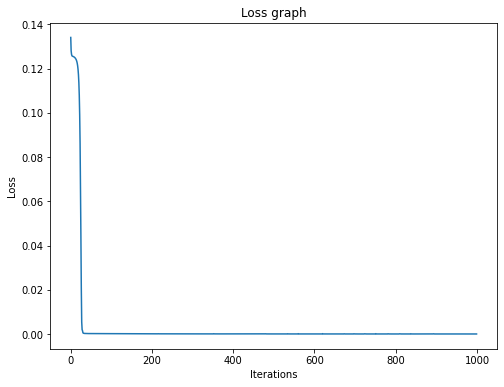

In [32]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Loss')
  
# giving a title to my graph
plt.title('Loss graph')
  
x = arr
y = model2.loss_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([0, 10**-2])
plt.show()

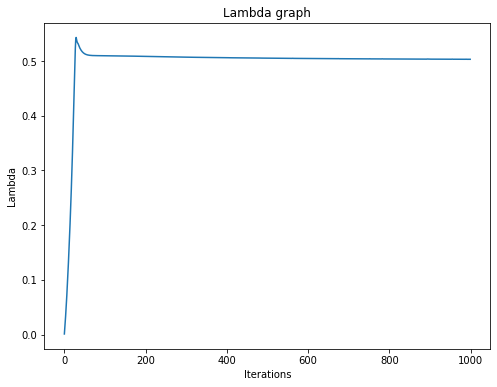

In [33]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Lambda')
  
# giving a title to my graph
plt.title('Lambda graph')
  
x = arr
y = model2.lambda_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([5.5, 6])
plt.show()

In [24]:
noise3 = 0.05    
u_train3 = u_train + noise3*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])

In [25]:
model3 = PhysicsInformedNN3(X_u_train, u_train3, layers2, lb1, ub1 , q_t)
model3.train(10000)

Device mapping:

It: 0, Loss: 1.325e+00, Lambda_1: -0.001, Lambda_2: 1.000000, Time: 0.16
It: 10, Loss: 8.230e-01, Lambda_1: -0.011, Lambda_2: 1.000000, Time: 0.02
It: 20, Loss: 4.835e-01, Lambda_1: -0.022, Lambda_2: 1.000000, Time: 0.01
It: 30, Loss: 2.852e-01, Lambda_1: -0.032, Lambda_2: 1.000000, Time: 0.01
It: 40, Loss: 1.897e-01, Lambda_1: -0.044, Lambda_2: 1.000000, Time: 0.01
It: 50, Loss: 1.548e-01, Lambda_1: -0.055, Lambda_2: 1.000000, Time: 0.01
It: 60, Loss: 1.469e-01, Lambda_1: -0.065, Lambda_2: 1.000000, Time: 0.01
It: 70, Loss: 1.465e-01, Lambda_1: -0.076, Lambda_2: 1.000000, Time: 0.01
It: 80, Loss: 1.468e-01, Lambda_1: -0.085, Lambda_2: 1.000000, Time: 0.01
It: 90, Loss: 1.466e-01, Lambda_1: -0.094, Lambda_2: 1.000000, Time: 0.01
It: 100, Loss: 1.464e-01, Lambda_1: -0.102, Lambda_2: 1.000000, Time: 0.01
It: 110, Loss: 1.463e-01, Lambda_1: -0.109, Lambda_2: 1.000000, Time: 0.01
It: 120, Loss: 1.463e-01, Lambda_1: -0.115, Lambda_2: 1.000000, Time: 0.01
It: 130, Loss: 1.46

It: 1160, Loss: 4.471e-03, Lambda_1: 0.662, Lambda_2: 1.000000, Time: 0.01
It: 1170, Loss: 4.260e-03, Lambda_1: 0.653, Lambda_2: 1.000000, Time: 0.01
It: 1180, Loss: 4.067e-03, Lambda_1: 0.645, Lambda_2: 1.000000, Time: 0.01
It: 1190, Loss: 3.891e-03, Lambda_1: 0.637, Lambda_2: 1.000000, Time: 0.01
It: 1200, Loss: 3.731e-03, Lambda_1: 0.630, Lambda_2: 1.000000, Time: 0.01
It: 1210, Loss: 3.585e-03, Lambda_1: 0.623, Lambda_2: 1.000000, Time: 0.01
It: 1220, Loss: 3.453e-03, Lambda_1: 0.616, Lambda_2: 1.000000, Time: 0.01
It: 1230, Loss: 3.332e-03, Lambda_1: 0.610, Lambda_2: 1.000000, Time: 0.01
It: 1240, Loss: 3.222e-03, Lambda_1: 0.604, Lambda_2: 1.000000, Time: 0.01
It: 1250, Loss: 3.122e-03, Lambda_1: 0.599, Lambda_2: 1.000000, Time: 0.01
It: 1260, Loss: 3.030e-03, Lambda_1: 0.594, Lambda_2: 1.000000, Time: 0.01
It: 1270, Loss: 2.946e-03, Lambda_1: 0.590, Lambda_2: 1.000000, Time: 0.01
It: 1280, Loss: 2.868e-03, Lambda_1: 0.586, Lambda_2: 1.000000, Time: 0.01
It: 1290, Loss: 2.797e-03

It: 2330, Loss: 3.093e-04, Lambda_1: 0.527, Lambda_2: 1.000000, Time: 0.01
It: 2340, Loss: 3.025e-04, Lambda_1: 0.527, Lambda_2: 1.000000, Time: 0.01
It: 2350, Loss: 2.959e-04, Lambda_1: 0.527, Lambda_2: 1.000000, Time: 0.01
It: 2360, Loss: 2.895e-04, Lambda_1: 0.527, Lambda_2: 1.000000, Time: 0.01
It: 2370, Loss: 2.833e-04, Lambda_1: 0.526, Lambda_2: 1.000000, Time: 0.01
It: 2380, Loss: 2.772e-04, Lambda_1: 0.526, Lambda_2: 1.000000, Time: 0.01
It: 2390, Loss: 2.713e-04, Lambda_1: 0.526, Lambda_2: 1.000000, Time: 0.01
It: 2400, Loss: 2.656e-04, Lambda_1: 0.526, Lambda_2: 1.000000, Time: 0.01
It: 2410, Loss: 2.600e-04, Lambda_1: 0.525, Lambda_2: 1.000000, Time: 0.01
It: 2420, Loss: 2.545e-04, Lambda_1: 0.525, Lambda_2: 1.000000, Time: 0.01
It: 2430, Loss: 2.493e-04, Lambda_1: 0.525, Lambda_2: 1.000000, Time: 0.01
It: 2440, Loss: 2.441e-04, Lambda_1: 0.525, Lambda_2: 1.000000, Time: 0.01
It: 2450, Loss: 2.391e-04, Lambda_1: 0.525, Lambda_2: 1.000000, Time: 0.01
It: 2460, Loss: 2.343e-04

It: 3440, Loss: 1.003e-04, Lambda_1: 0.511, Lambda_2: 1.000000, Time: 0.02
It: 3450, Loss: 1.002e-04, Lambda_1: 0.511, Lambda_2: 1.000000, Time: 0.02
It: 3460, Loss: 1.001e-04, Lambda_1: 0.511, Lambda_2: 1.000000, Time: 0.02
It: 3470, Loss: 1.000e-04, Lambda_1: 0.511, Lambda_2: 1.000000, Time: 0.02
It: 3480, Loss: 9.993e-05, Lambda_1: 0.511, Lambda_2: 1.000000, Time: 0.02
It: 3490, Loss: 9.985e-05, Lambda_1: 0.511, Lambda_2: 1.000000, Time: 0.02
It: 3500, Loss: 9.978e-05, Lambda_1: 0.511, Lambda_2: 1.000000, Time: 0.02
It: 3510, Loss: 9.971e-05, Lambda_1: 0.511, Lambda_2: 1.000000, Time: 0.02
It: 3520, Loss: 9.964e-05, Lambda_1: 0.511, Lambda_2: 1.000000, Time: 0.02
It: 3530, Loss: 9.957e-05, Lambda_1: 0.511, Lambda_2: 1.000000, Time: 0.02
It: 3540, Loss: 9.950e-05, Lambda_1: 0.511, Lambda_2: 1.000000, Time: 0.02
It: 3550, Loss: 9.944e-05, Lambda_1: 0.511, Lambda_2: 1.000000, Time: 0.02
It: 3560, Loss: 9.938e-05, Lambda_1: 0.511, Lambda_2: 1.000000, Time: 0.02
It: 3570, Loss: 9.932e-05

It: 4570, Loss: 9.600e-05, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.02
It: 4580, Loss: 9.598e-05, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.02
It: 4590, Loss: 9.595e-05, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.02
It: 4600, Loss: 9.593e-05, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.02
It: 4610, Loss: 9.591e-05, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.03
It: 4620, Loss: 9.589e-05, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.02
It: 4630, Loss: 9.587e-05, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.02
It: 4640, Loss: 9.585e-05, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.02
It: 4650, Loss: 9.583e-05, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.02
It: 4660, Loss: 9.580e-05, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.02
It: 4670, Loss: 9.578e-05, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.02
It: 4680, Loss: 9.576e-05, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.02
It: 4690, Loss: 9.574e-05, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.02
It: 4700, Loss: 9.572e-05

It: 5750, Loss: 9.400e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.02
It: 5760, Loss: 9.399e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.02
It: 5770, Loss: 9.397e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.02
It: 5780, Loss: 9.396e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.02
It: 5790, Loss: 9.395e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.02
It: 5800, Loss: 9.393e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.02
It: 5810, Loss: 9.392e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.02
It: 5820, Loss: 9.391e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.02
It: 5830, Loss: 9.389e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.02
It: 5840, Loss: 9.388e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.03
It: 5850, Loss: 9.387e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.02
It: 5860, Loss: 9.386e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.02
It: 5870, Loss: 9.384e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.03
It: 5880, Loss: 9.383e-05

It: 7010, Loss: 9.257e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 7020, Loss: 9.256e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 7030, Loss: 9.255e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 7040, Loss: 9.254e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 7050, Loss: 9.253e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 7060, Loss: 9.252e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 7070, Loss: 9.251e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 7080, Loss: 9.250e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 7090, Loss: 9.249e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 7100, Loss: 9.248e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 7110, Loss: 9.247e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 7120, Loss: 9.247e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 7130, Loss: 9.246e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 7140, Loss: 9.245e-05

It: 8260, Loss: 9.214e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 8270, Loss: 9.368e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 8280, Loss: 9.254e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 8290, Loss: 9.170e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 8300, Loss: 9.184e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 8310, Loss: 9.167e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 8320, Loss: 9.166e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 8330, Loss: 9.165e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 8340, Loss: 9.164e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 8350, Loss: 9.163e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 8360, Loss: 9.163e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 8370, Loss: 9.162e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 8380, Loss: 9.162e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 8390, Loss: 9.162e-05

It: 9440, Loss: 9.130e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 9450, Loss: 9.129e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 9460, Loss: 9.129e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 9470, Loss: 9.130e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 9480, Loss: 9.201e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 9490, Loss: 1.039e-04, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 9500, Loss: 9.319e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 9510, Loss: 9.132e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 9520, Loss: 9.166e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 9530, Loss: 9.149e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 9540, Loss: 9.129e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 9550, Loss: 9.129e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 9560, Loss: 9.128e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 9570, Loss: 9.127e-05

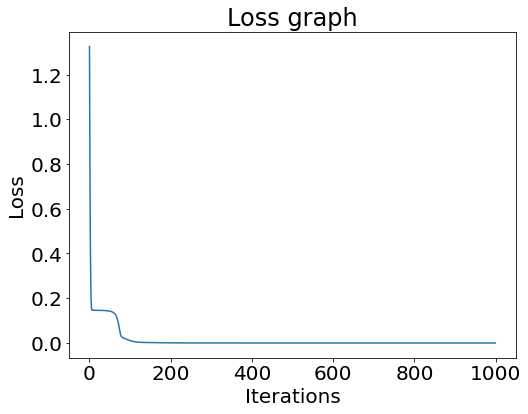

In [26]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Loss')
  
# giving a title to my graph
plt.title('Loss graph')
  
x = arr
y = model3.loss_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([0, 10**-2])
plt.show()

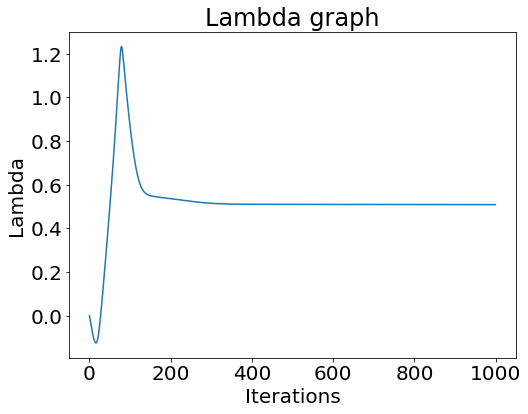

In [27]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Lambda')
  
# giving a title to my graph
plt.title('Lambda graph')
  
x = arr
y = model3.lambda_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([5.5, 6])
plt.show()

In [34]:
noise4 = 0.10 
u_train4 = u_train + noise4*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])

In [35]:
model4 = PhysicsInformedNN3(X_u_train, u_train4, layers2, lb1, ub1 , q_t)
model4.train(10000)

Device mapping:

It: 0, Loss: 3.921e-01, Lambda_1: -0.001, Lambda_2: 1.000000, Time: 0.23
It: 10, Loss: 2.014e-01, Lambda_1: -0.011, Lambda_2: 1.000000, Time: 0.01
It: 20, Loss: 1.465e-01, Lambda_1: -0.020, Lambda_2: 1.000000, Time: 0.01
It: 30, Loss: 1.492e-01, Lambda_1: -0.029, Lambda_2: 1.000000, Time: 0.01
It: 40, Loss: 1.484e-01, Lambda_1: -0.037, Lambda_2: 1.000000, Time: 0.01
It: 50, Loss: 1.454e-01, Lambda_1: -0.043, Lambda_2: 1.000000, Time: 0.01
It: 60, Loss: 1.454e-01, Lambda_1: -0.046, Lambda_2: 1.000000, Time: 0.01
It: 70, Loss: 1.453e-01, Lambda_1: -0.047, Lambda_2: 1.000000, Time: 0.01
It: 80, Loss: 1.452e-01, Lambda_1: -0.044, Lambda_2: 1.000000, Time: 0.01
It: 90, Loss: 1.451e-01, Lambda_1: -0.037, Lambda_2: 1.000000, Time: 0.01
It: 100, Loss: 1.451e-01, Lambda_1: -0.027, Lambda_2: 1.000000, Time: 0.01
It: 110, Loss: 1.450e-01, Lambda_1: -0.013, Lambda_2: 1.000000, Time: 0.01
It: 120, Loss: 1.450e-01, Lambda_1: 0.003, Lambda_2: 1.000000, Time: 0.01
It: 130, Loss: 1.449

It: 1190, Loss: 1.220e-03, Lambda_1: 0.515, Lambda_2: 1.000000, Time: 0.01
It: 1200, Loss: 1.212e-03, Lambda_1: 0.515, Lambda_2: 1.000000, Time: 0.01
It: 1210, Loss: 1.204e-03, Lambda_1: 0.515, Lambda_2: 1.000000, Time: 0.01
It: 1220, Loss: 1.196e-03, Lambda_1: 0.515, Lambda_2: 1.000000, Time: 0.01
It: 1230, Loss: 1.189e-03, Lambda_1: 0.514, Lambda_2: 1.000000, Time: 0.01
It: 1240, Loss: 1.181e-03, Lambda_1: 0.514, Lambda_2: 1.000000, Time: 0.01
It: 1250, Loss: 1.174e-03, Lambda_1: 0.514, Lambda_2: 1.000000, Time: 0.01
It: 1260, Loss: 1.167e-03, Lambda_1: 0.514, Lambda_2: 1.000000, Time: 0.01
It: 1270, Loss: 1.159e-03, Lambda_1: 0.514, Lambda_2: 1.000000, Time: 0.01
It: 1280, Loss: 1.153e-03, Lambda_1: 0.513, Lambda_2: 1.000000, Time: 0.01
It: 1290, Loss: 1.146e-03, Lambda_1: 0.513, Lambda_2: 1.000000, Time: 0.01
It: 1300, Loss: 1.139e-03, Lambda_1: 0.513, Lambda_2: 1.000000, Time: 0.01
It: 1310, Loss: 1.132e-03, Lambda_1: 0.513, Lambda_2: 1.000000, Time: 0.01
It: 1320, Loss: 1.126e-03

It: 2410, Loss: 6.494e-04, Lambda_1: 0.499, Lambda_2: 1.000000, Time: 0.01
It: 2420, Loss: 6.468e-04, Lambda_1: 0.499, Lambda_2: 1.000000, Time: 0.01
It: 2430, Loss: 6.442e-04, Lambda_1: 0.499, Lambda_2: 1.000000, Time: 0.01
It: 2440, Loss: 6.416e-04, Lambda_1: 0.499, Lambda_2: 1.000000, Time: 0.01
It: 2450, Loss: 6.391e-04, Lambda_1: 0.499, Lambda_2: 1.000000, Time: 0.01
It: 2460, Loss: 6.365e-04, Lambda_1: 0.499, Lambda_2: 1.000000, Time: 0.01
It: 2470, Loss: 6.341e-04, Lambda_1: 0.499, Lambda_2: 1.000000, Time: 0.01
It: 2480, Loss: 6.316e-04, Lambda_1: 0.499, Lambda_2: 1.000000, Time: 0.01
It: 2490, Loss: 6.292e-04, Lambda_1: 0.498, Lambda_2: 1.000000, Time: 0.01
It: 2500, Loss: 6.268e-04, Lambda_1: 0.498, Lambda_2: 1.000000, Time: 0.01
It: 2510, Loss: 6.245e-04, Lambda_1: 0.498, Lambda_2: 1.000000, Time: 0.01
It: 2520, Loss: 6.222e-04, Lambda_1: 0.498, Lambda_2: 1.000000, Time: 0.01
It: 2530, Loss: 6.199e-04, Lambda_1: 0.498, Lambda_2: 1.000000, Time: 0.01
It: 2540, Loss: 6.176e-04

It: 3550, Loss: 5.273e-04, Lambda_1: 0.490, Lambda_2: 1.000000, Time: 0.02
It: 3560, Loss: 5.272e-04, Lambda_1: 0.490, Lambda_2: 1.000000, Time: 0.03
It: 3570, Loss: 5.270e-04, Lambda_1: 0.490, Lambda_2: 1.000000, Time: 0.03
It: 3580, Loss: 5.269e-04, Lambda_1: 0.490, Lambda_2: 1.000000, Time: 0.03
It: 3590, Loss: 5.267e-04, Lambda_1: 0.490, Lambda_2: 1.000000, Time: 0.02
It: 3600, Loss: 5.266e-04, Lambda_1: 0.490, Lambda_2: 1.000000, Time: 0.02
It: 3610, Loss: 5.264e-04, Lambda_1: 0.490, Lambda_2: 1.000000, Time: 0.02
It: 3620, Loss: 5.263e-04, Lambda_1: 0.490, Lambda_2: 1.000000, Time: 0.02
It: 3630, Loss: 5.262e-04, Lambda_1: 0.490, Lambda_2: 1.000000, Time: 0.03
It: 3640, Loss: 5.260e-04, Lambda_1: 0.490, Lambda_2: 1.000000, Time: 0.02
It: 3650, Loss: 5.259e-04, Lambda_1: 0.490, Lambda_2: 1.000000, Time: 0.02
It: 3660, Loss: 5.258e-04, Lambda_1: 0.490, Lambda_2: 1.000000, Time: 0.02
It: 3670, Loss: 5.257e-04, Lambda_1: 0.490, Lambda_2: 1.000000, Time: 0.02
It: 3680, Loss: 5.256e-04

It: 4690, Loss: 5.201e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.02
It: 4700, Loss: 5.200e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.03
It: 4710, Loss: 5.200e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.02
It: 4720, Loss: 5.200e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.02
It: 4730, Loss: 5.199e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.02
It: 4740, Loss: 5.199e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.02
It: 4750, Loss: 5.199e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.02
It: 4760, Loss: 5.199e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.02
It: 4770, Loss: 5.198e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.02
It: 4780, Loss: 5.198e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.03
It: 4790, Loss: 5.198e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.02
It: 4800, Loss: 5.197e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.03
It: 4810, Loss: 5.197e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.03
It: 4820, Loss: 5.197e-04

It: 5850, Loss: 5.174e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.03
It: 5860, Loss: 5.175e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.03
It: 5870, Loss: 5.330e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.02
It: 5880, Loss: 5.228e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.02
It: 5890, Loss: 5.187e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.02
It: 5900, Loss: 5.173e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.02
It: 5910, Loss: 5.175e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.02
It: 5920, Loss: 5.172e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.02
It: 5930, Loss: 5.172e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.03
It: 5940, Loss: 5.172e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.02
It: 5950, Loss: 5.172e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.02
It: 5960, Loss: 5.171e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.02
It: 5970, Loss: 5.171e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.02
It: 5980, Loss: 5.171e-04

It: 7090, Loss: 5.151e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 7100, Loss: 5.151e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 7110, Loss: 5.151e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 7120, Loss: 5.151e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 7130, Loss: 5.151e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 7140, Loss: 5.151e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 7150, Loss: 5.150e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 7160, Loss: 5.150e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 7170, Loss: 5.150e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 7180, Loss: 5.150e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 7190, Loss: 5.150e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 7200, Loss: 5.150e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 7210, Loss: 5.149e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 7220, Loss: 5.149e-04

It: 8250, Loss: 5.136e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 8260, Loss: 5.136e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 8270, Loss: 5.136e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 8280, Loss: 5.136e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 8290, Loss: 5.136e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 8300, Loss: 5.136e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 8310, Loss: 5.205e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 8320, Loss: 5.139e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 8330, Loss: 5.197e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 8340, Loss: 5.160e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 8350, Loss: 5.137e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 8360, Loss: 5.136e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 8370, Loss: 5.136e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 8380, Loss: 5.135e-04

It: 9400, Loss: 5.182e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 9410, Loss: 5.138e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 9420, Loss: 5.126e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 9430, Loss: 5.127e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 9440, Loss: 5.127e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 9450, Loss: 5.126e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 9460, Loss: 5.126e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 9470, Loss: 5.125e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 9480, Loss: 5.125e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 9490, Loss: 5.125e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 9500, Loss: 5.125e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 9510, Loss: 5.125e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 9520, Loss: 5.125e-04, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 9530, Loss: 5.125e-04

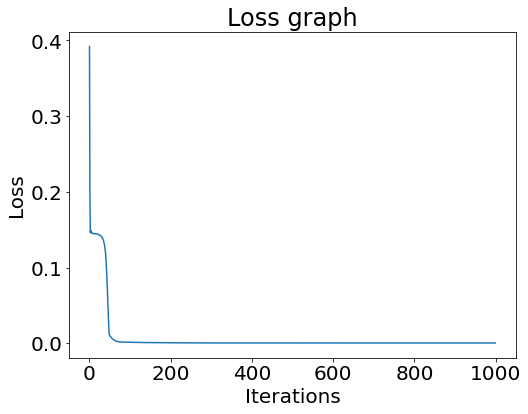

In [36]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Loss')
  
# giving a title to my graph
plt.title('Loss graph')
  
x = arr
y = model4.loss_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([0, 10**-2])
plt.show()

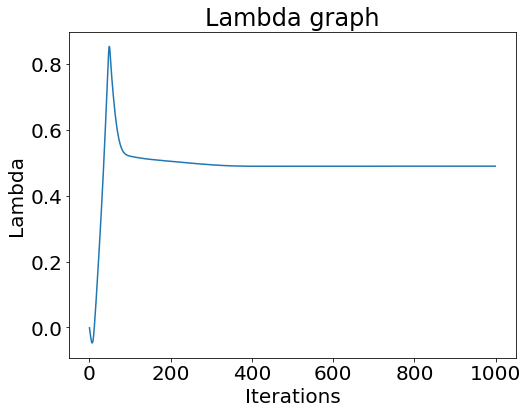

In [37]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Lambda')
  
# giving a title to my graph
plt.title('Lambda graph')
  
x = arr
y = model4.lambda_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([5.5, 6])
plt.show()

In [50]:
noise5 = 0.25
u_train5 = u_train + noise5*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])

In [51]:
model5 = PhysicsInformedNN3(X_u_train, u_train5, layers2, lb1, ub1 , q_t)
model5.train(10000)

Device mapping:

It: 0, Loss: 8.461e-01, Lambda_1: -0.001, Lambda_2: 1.000000, Time: 0.33
It: 10, Loss: 4.887e-01, Lambda_1: -0.011, Lambda_2: 1.000000, Time: 0.01
It: 20, Loss: 2.720e-01, Lambda_1: -0.021, Lambda_2: 1.000000, Time: 0.01
It: 30, Loss: 1.716e-01, Lambda_1: -0.031, Lambda_2: 1.000000, Time: 0.01
It: 40, Loss: 1.421e-01, Lambda_1: -0.041, Lambda_2: 1.000000, Time: 0.01
It: 50, Loss: 1.397e-01, Lambda_1: -0.051, Lambda_2: 1.000000, Time: 0.01
It: 60, Loss: 1.407e-01, Lambda_1: -0.059, Lambda_2: 1.000000, Time: 0.01
It: 70, Loss: 1.402e-01, Lambda_1: -0.067, Lambda_2: 1.000000, Time: 0.01
It: 80, Loss: 1.396e-01, Lambda_1: -0.072, Lambda_2: 1.000000, Time: 0.01
It: 90, Loss: 1.394e-01, Lambda_1: -0.076, Lambda_2: 1.000000, Time: 0.01
It: 100, Loss: 1.394e-01, Lambda_1: -0.078, Lambda_2: 1.000000, Time: 0.01
It: 110, Loss: 1.394e-01, Lambda_1: -0.077, Lambda_2: 1.000000, Time: 0.01
It: 120, Loss: 1.394e-01, Lambda_1: -0.074, Lambda_2: 1.000000, Time: 0.01
It: 130, Loss: 1.39

It: 1200, Loss: 5.004e-03, Lambda_1: 0.595, Lambda_2: 1.000000, Time: 0.01
It: 1210, Loss: 4.961e-03, Lambda_1: 0.592, Lambda_2: 1.000000, Time: 0.01
It: 1220, Loss: 4.922e-03, Lambda_1: 0.589, Lambda_2: 1.000000, Time: 0.01
It: 1230, Loss: 4.886e-03, Lambda_1: 0.586, Lambda_2: 1.000000, Time: 0.01
It: 1240, Loss: 4.853e-03, Lambda_1: 0.584, Lambda_2: 1.000000, Time: 0.01
It: 1250, Loss: 4.822e-03, Lambda_1: 0.581, Lambda_2: 1.000000, Time: 0.01
It: 1260, Loss: 4.792e-03, Lambda_1: 0.579, Lambda_2: 1.000000, Time: 0.01
It: 1270, Loss: 4.764e-03, Lambda_1: 0.577, Lambda_2: 1.000000, Time: 0.01
It: 1280, Loss: 4.738e-03, Lambda_1: 0.576, Lambda_2: 1.000000, Time: 0.01
It: 1290, Loss: 4.713e-03, Lambda_1: 0.574, Lambda_2: 1.000000, Time: 0.01
It: 1300, Loss: 4.689e-03, Lambda_1: 0.573, Lambda_2: 1.000000, Time: 0.01
It: 1310, Loss: 4.666e-03, Lambda_1: 0.571, Lambda_2: 1.000000, Time: 0.01
It: 1320, Loss: 4.644e-03, Lambda_1: 0.570, Lambda_2: 1.000000, Time: 0.01
It: 1330, Loss: 4.623e-03

It: 2400, Loss: 3.786e-03, Lambda_1: 0.544, Lambda_2: 1.000000, Time: 0.01
It: 2410, Loss: 3.784e-03, Lambda_1: 0.544, Lambda_2: 1.000000, Time: 0.01
It: 2420, Loss: 3.781e-03, Lambda_1: 0.544, Lambda_2: 1.000000, Time: 0.01
It: 2430, Loss: 3.779e-03, Lambda_1: 0.544, Lambda_2: 1.000000, Time: 0.01
It: 2440, Loss: 3.776e-03, Lambda_1: 0.543, Lambda_2: 1.000000, Time: 0.01
It: 2450, Loss: 3.774e-03, Lambda_1: 0.543, Lambda_2: 1.000000, Time: 0.01
It: 2460, Loss: 3.772e-03, Lambda_1: 0.543, Lambda_2: 1.000000, Time: 0.01
It: 2470, Loss: 3.769e-03, Lambda_1: 0.543, Lambda_2: 1.000000, Time: 0.01
It: 2480, Loss: 3.767e-03, Lambda_1: 0.543, Lambda_2: 1.000000, Time: 0.01
It: 2490, Loss: 3.765e-03, Lambda_1: 0.543, Lambda_2: 1.000000, Time: 0.01
It: 2500, Loss: 3.763e-03, Lambda_1: 0.543, Lambda_2: 1.000000, Time: 0.01
It: 2510, Loss: 3.761e-03, Lambda_1: 0.542, Lambda_2: 1.000000, Time: 0.01
It: 2520, Loss: 3.759e-03, Lambda_1: 0.542, Lambda_2: 1.000000, Time: 0.01
It: 2530, Loss: 3.757e-03

It: 3550, Loss: 3.584e-03, Lambda_1: 0.533, Lambda_2: 1.000000, Time: 0.03
It: 3560, Loss: 3.582e-03, Lambda_1: 0.533, Lambda_2: 1.000000, Time: 0.03
It: 3570, Loss: 3.579e-03, Lambda_1: 0.533, Lambda_2: 1.000000, Time: 0.02
It: 3580, Loss: 3.576e-03, Lambda_1: 0.533, Lambda_2: 1.000000, Time: 0.02
It: 3590, Loss: 3.574e-03, Lambda_1: 0.533, Lambda_2: 1.000000, Time: 0.02
It: 3600, Loss: 3.571e-03, Lambda_1: 0.533, Lambda_2: 1.000000, Time: 0.02
It: 3610, Loss: 3.568e-03, Lambda_1: 0.533, Lambda_2: 1.000000, Time: 0.03
It: 3620, Loss: 3.565e-03, Lambda_1: 0.533, Lambda_2: 1.000000, Time: 0.02
It: 3630, Loss: 3.563e-03, Lambda_1: 0.533, Lambda_2: 1.000000, Time: 0.02
It: 3640, Loss: 3.560e-03, Lambda_1: 0.533, Lambda_2: 1.000000, Time: 0.02
It: 3650, Loss: 3.557e-03, Lambda_1: 0.533, Lambda_2: 1.000000, Time: 0.02
It: 3660, Loss: 3.554e-03, Lambda_1: 0.533, Lambda_2: 1.000000, Time: 0.02
It: 3670, Loss: 3.551e-03, Lambda_1: 0.533, Lambda_2: 1.000000, Time: 0.02
It: 3680, Loss: 3.548e-03

It: 4750, Loss: 3.131e-03, Lambda_1: 0.533, Lambda_2: 1.000000, Time: 0.01
It: 4760, Loss: 3.129e-03, Lambda_1: 0.533, Lambda_2: 1.000000, Time: 0.01
It: 4770, Loss: 3.126e-03, Lambda_1: 0.533, Lambda_2: 1.000000, Time: 0.01
It: 4780, Loss: 3.124e-03, Lambda_1: 0.533, Lambda_2: 1.000000, Time: 0.01
It: 4790, Loss: 3.122e-03, Lambda_1: 0.533, Lambda_2: 1.000000, Time: 0.01
It: 4800, Loss: 3.119e-03, Lambda_1: 0.533, Lambda_2: 1.000000, Time: 0.01
It: 4810, Loss: 3.117e-03, Lambda_1: 0.533, Lambda_2: 1.000000, Time: 0.01
It: 4820, Loss: 3.115e-03, Lambda_1: 0.533, Lambda_2: 1.000000, Time: 0.01
It: 4830, Loss: 3.113e-03, Lambda_1: 0.533, Lambda_2: 1.000000, Time: 0.01
It: 4840, Loss: 3.111e-03, Lambda_1: 0.533, Lambda_2: 1.000000, Time: 0.01
It: 4850, Loss: 3.109e-03, Lambda_1: 0.533, Lambda_2: 1.000000, Time: 0.01
It: 4860, Loss: 3.107e-03, Lambda_1: 0.533, Lambda_2: 1.000000, Time: 0.01
It: 4870, Loss: 3.105e-03, Lambda_1: 0.533, Lambda_2: 1.000000, Time: 0.01
It: 4880, Loss: 3.103e-03

It: 5910, Loss: 3.007e-03, Lambda_1: 0.537, Lambda_2: 1.000000, Time: 0.01
It: 5920, Loss: 3.007e-03, Lambda_1: 0.537, Lambda_2: 1.000000, Time: 0.01
It: 5930, Loss: 3.007e-03, Lambda_1: 0.537, Lambda_2: 1.000000, Time: 0.01
It: 5940, Loss: 3.006e-03, Lambda_1: 0.537, Lambda_2: 1.000000, Time: 0.01
It: 5950, Loss: 3.007e-03, Lambda_1: 0.537, Lambda_2: 1.000000, Time: 0.01
It: 5960, Loss: 3.006e-03, Lambda_1: 0.537, Lambda_2: 1.000000, Time: 0.01
It: 5970, Loss: 3.005e-03, Lambda_1: 0.537, Lambda_2: 1.000000, Time: 0.01
It: 5980, Loss: 3.005e-03, Lambda_1: 0.537, Lambda_2: 1.000000, Time: 0.01
It: 5990, Loss: 3.004e-03, Lambda_1: 0.537, Lambda_2: 1.000000, Time: 0.01
It: 6000, Loss: 3.004e-03, Lambda_1: 0.537, Lambda_2: 1.000000, Time: 0.01
It: 6010, Loss: 3.004e-03, Lambda_1: 0.537, Lambda_2: 1.000000, Time: 0.01
It: 6020, Loss: 3.003e-03, Lambda_1: 0.537, Lambda_2: 1.000000, Time: 0.01
It: 6030, Loss: 3.003e-03, Lambda_1: 0.537, Lambda_2: 1.000000, Time: 0.01
It: 6040, Loss: 3.003e-03

It: 7060, Loss: 2.983e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 7070, Loss: 2.983e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 7080, Loss: 2.983e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 7090, Loss: 2.983e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 7100, Loss: 2.982e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 7110, Loss: 2.982e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 7120, Loss: 2.982e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 7130, Loss: 2.982e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 7140, Loss: 2.982e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 7150, Loss: 2.982e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 7160, Loss: 2.982e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 7170, Loss: 2.982e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 7180, Loss: 2.981e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 7190, Loss: 2.981e-03

It: 8160, Loss: 2.974e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 8170, Loss: 2.973e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 8180, Loss: 2.970e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 8190, Loss: 2.970e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 8200, Loss: 2.969e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 8210, Loss: 2.969e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 8220, Loss: 2.969e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 8230, Loss: 2.968e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 8240, Loss: 2.968e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 8250, Loss: 2.968e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 8260, Loss: 2.968e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 8270, Loss: 2.968e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 8280, Loss: 2.968e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 8290, Loss: 2.968e-03

It: 9300, Loss: 2.955e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 9310, Loss: 2.954e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 9320, Loss: 2.954e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 9330, Loss: 2.954e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 9340, Loss: 2.954e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 9350, Loss: 2.954e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 9360, Loss: 2.954e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 9370, Loss: 2.953e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 9380, Loss: 2.953e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 9390, Loss: 2.960e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 9400, Loss: 2.961e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 9410, Loss: 2.953e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 9420, Loss: 2.953e-03, Lambda_1: 0.538, Lambda_2: 1.000000, Time: 0.01
It: 9430, Loss: 2.953e-03

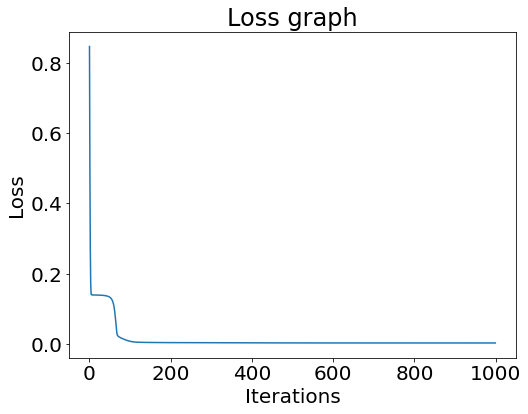

In [52]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Loss')
  
# giving a title to my graph
plt.title('Loss graph')
  
x = arr
y = model5.loss_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([0, 10**-2])
plt.show()

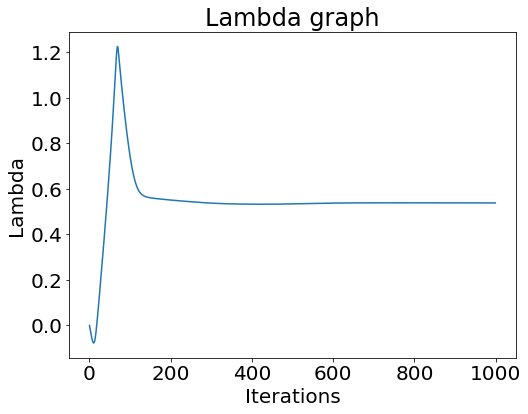

In [53]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Lambda')
  
# giving a title to my graph
plt.title('Lambda graph')
  
x = arr
y = model5.lambda_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([5.5, 6])
plt.show()